![Rampart Logo](../images/logo.png)

Auge is an image classification model. Its main target's to recognize common photos to determine a few flat publication's features. Each image belongs to a specific realty, having a bunch of photo & panorama recognized **twinkle** can better predict apartments' order.

## I/O
Required images lie at `../scientific/images`. Final classifier must be stored into `../models/auge.latest.pth`.

## Metadata
Each image file has a self-explained name looking like:
```
<hash>.<effect>.<group>.<label>.webp
```
For instance:
```
0018559490dd9cb73caa00f078fde40b220803de.balance_down_hue_cw_rotate_ccw_crop.training.construction.webp
```
Placeholders in angle brackets:
- `hash`, SHA-1 sum of the image URL.
- `effect`, image filters used to augment the initial photo. An unchaged file has `origin` here.
- `group`, the dataset image belongs to. Can be one of `training`, `validation` & `testing` .
- `label`, expected image class. See the details below.

## Classes
- `luxury` is a flat with rich furniture, huge rooms, chandeliers, fireplaces, etc.

![Luxury 1](../images/luxury1.webp)
![Luxury 2](../images/luxury2.webp)
![Luxury 3](../images/luxury3.webp)

- `comfort` is the most suitable for an ordinary citizen apartments. Clean, neat, sometimes minimalistic, average area, qualitive furniture, etc.

![Comfort 1](../images/comfort1.webp)
![Comfort 2](../images/comfort2.webp)
![Comfort 3](../images/comfort3.webp)

- `junk` is an old flat image. Probably, the whole apartments should belong to a dormitory, Khrushchevka or gostinka.

![Junk 1](../images/junk1.webp)
![Junk 2](../images/junk2.webp)
![Junk 3](../images/junk3.webp)

- `construction` is a flat without a finished design. No doors, floor, supplies, wallpapers, ceiling, furniture, etc. Typically, new buildings contain these apartments.

![Construction 1](../images/construction1.webp)
![Construction 2](../images/construction2.webp)
![Construction 3](../images/construction3.webp)

- `excess` is the trash category. Actually, all exterior photos, outlines & posters lie here.

![Excess 1](../images/excess1.webp)
![Excess 2](../images/excess2.webp)
![Excess 3](../images/excess3.webp)

In [1]:
from plotly.graph_objs import Pie, Figure, Scatter
from plotly.figure_factory import create_annotated_heatmap
from plotly.subplots import make_subplots
from re import match
from numpy import arange, trace, sum
from glob import glob
from pandas import DataFrame, concat
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models import inception_v3
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch import no_grad, save, max, load, zeros, cat, long, set_num_threads, get_num_threads
from uuid import uuid4
from PIL.Image import open
from multiprocessing import cpu_count

In [2]:
%matplotlib inline
set_num_threads(cpu_count())
print(f'Set thread number to {get_num_threads()}.')

Set thread number to 8.


In [3]:
groups = {'training', 'validation', 'testing'}
interiors = ['luxury', 'comfort', 'junk', 'construction', 'excess']

In [4]:
def parse(path, mappings):
    result = match(r'^.*/\w+\.\w+\.(\w+)\.(\w+)\.webp$', path)
    if not result:
        raise RuntimeError(f'Got invalid path, {path}')
    expressions = result.groups()
    if expressions[0] not in groups:
        raise RuntimeError(f'Got invalid group, {path}')
    if expressions[1] not in mappings:
        raise RuntimeError(f'Got invalid interior, {path}')
    return path, expressions[0], mappings[expressions[1]]

In [5]:
def extract():
    mappings = {l: i for i, l in enumerate(interiors)}
    return DataFrame(
        map(lambda p: parse(p, mappings), glob('../scientific/images/*.webp')),
        columns=['path', 'group', 'interior']
    )

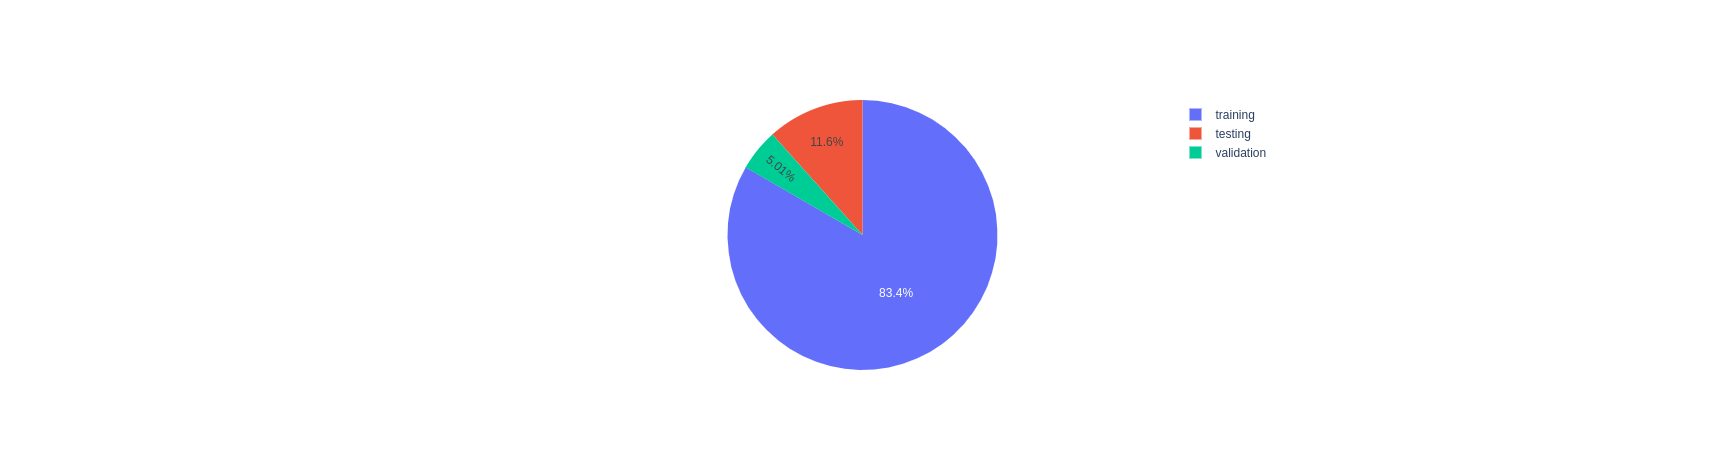

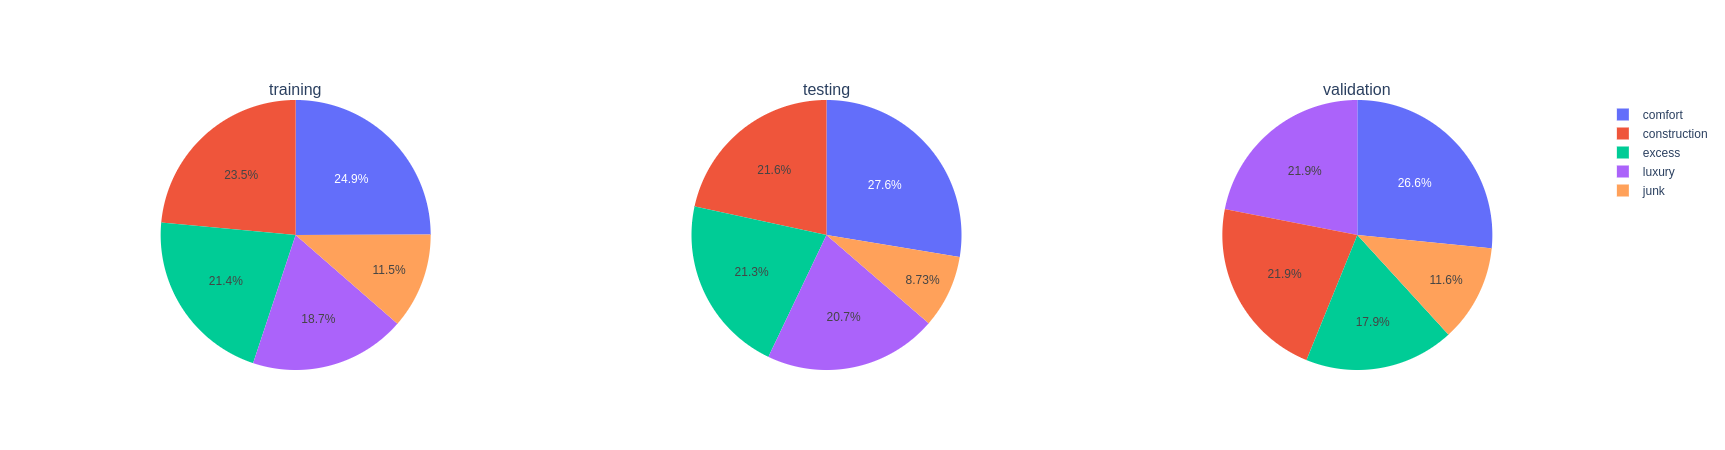

In [7]:
images = extract()
figure = Figure()
counts = images['group'].value_counts()
figure.add_trace(Pie(labels=counts.index, values=counts.values, name=''))
figure.update_layout(legend={'x': 0.7})
figure.show()
figure = make_subplots(
    cols=len(groups),
    specs=[[{'type': 'domain'}] * len(groups)],
    subplot_titles=list(groups)
)
for i, group in enumerate(groups, 1):
    counts = images[images['group'] == group]['interior'].value_counts().sort_index()
    figure.add_trace(
        Pie(labels=[interiors[j] for j in counts.index], values=counts.values, name=''),
        row=1,
        col=i
    )
figure.show()

In [8]:
class Gallery(Dataset):
    def __init__(self, data):
        self._data = data.values
        self._transforms = Compose(
            [ToTensor(), Resize((299, 299)), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
        )

    def __getitem__(self, index):
        return self._transforms(open(self._data[index][0])), self._data[index][2], self._data[index][0]

    def __len__(self):
        return len(self._data)

In [9]:
batch_size = 8
training_loader = DataLoader(Gallery(images[images['group'] == 'training']), batch_size, True)
validation_loader = DataLoader(Gallery(images[images['group'] == 'validation']), batch_size)
testing_loader = DataLoader(Gallery(images[images['group'] == 'testing']), batch_size)
print(len(training_loader), len(validation_loader), len(testing_loader))

10014 602 1398


In [10]:
def train():
    network = inception_v3(num_classes=len(interiors), init_weights=True)
    criterion = CrossEntropyLoss()
    optimizer = Adam(network.parameters(), weight_decay=0.0001)
    epoch_number = 8
    epochs = arange(epoch_number)
    training_losses = [0.0] * epoch_number
    training_accuracies = [0.0] * epoch_number
    auxiliary_losses = [0.0] * epoch_number
    auxiliary_accuracies = [0.0] * epoch_number
    validation_losses = [0.0] * epoch_number
    validation_accuracies = [0.0] * epoch_number
    for epoch in epochs:
        network.train()
        total = 0
        for batch in training_loader:
            outputs = network(batch[0])
            optimizer.zero_grad()
            training_loss = criterion(outputs[0], batch[1])
            auxiliary_loss = criterion(outputs[1], batch[1])
            (training_loss + 0.4 * auxiliary_loss).backward()
            optimizer.step()
            training_losses[epoch] += training_loss.item() * batch[0].size(0)
            training_accuracies[epoch] += (max(outputs[0], 1)[1] == batch[1]).float().sum().item()
            auxiliary_losses[epoch] += auxiliary_loss.item() * batch[0].size(0)
            auxiliary_accuracies[epoch] += (max(outputs[1], 1)[1] == batch[1]).float().sum().item()
            total += batch[0].size(0)
        training_losses[epoch] /= len(training_loader)
        training_accuracies[epoch] *= 100 / total
        auxiliary_losses[epoch] /= len(training_loader)
        auxiliary_accuracies[epoch] *= 100 / total
        network.eval()
        total = 0
        with no_grad():
            for batch in validation_loader:
                output = network(batch[0])
                validation_losses[epoch] += criterion(output, batch[1]).item() * batch[0].size(0)
                validation_accuracies[epoch] += (max(output, 1)[1] == batch[1]).float().sum().item()
                total += batch[0].size(0)
        validation_losses[epoch] /= len(validation_loader)
        validation_accuracies[epoch] *= 100 / total
    state = network.state_dict()
    save(state, f'../scientific/models/auge.{uuid4().hex}.pth')
    save(state, '../scientific/models/auge.latest.pth')
    reflect(epochs, training_losses, auxiliary_losses, validation_losses, 'Loss')
    reflect(epochs, training_accuracies, auxiliary_accuracies, validation_accuracies, 'Accuracy')
    return network

In [11]:
def reflect(epochs, training, auxiliary, validation, title):
    figure = Figure()
    figure.add_trace(Scatter(x=epochs, y=training, name='Training'))
    figure.add_trace(Scatter(x=epochs, y=auxiliary, name='Auxiliary'))
    figure.add_trace(Scatter(x=epochs, y=validation, name='Validation'))
    figure.update_layout(title=title)
    figure.show()

In [12]:
def test(network):
    network.eval()
    predicted = zeros(0, dtype=long)
    actual = zeros(0, dtype=long)
    with no_grad():
        for batch in testing_loader:
            predicted = cat([predicted, max(network(batch[0]), 1)[1].view(-1)])
            actual = cat([actual, batch[1].view(-1)])
    matrix = confusion_matrix(actual, predicted)
    figure = create_annotated_heatmap(z=matrix, x=interiors, y=interiors, hoverinfo='skip')
    figure.update_xaxes(title_text='Predicted')
    figure.update_yaxes(title_text='Actual', autorange='reversed')
    figure.update_layout(title=f'Accuracy: {trace(matrix) / sum(matrix) * 100:.2f}%')
    figure.show()

In [ ]:
%%time
test(train())

In [ ]:
def use(tag='latest'):
    network = inception_v3(num_classes=len(interiors), init_weights=False)
    network.load_state_dict(load(f'../scientific/models/auge.{tag}.pth'))
    return network

In [ ]:
%%time
test(use())